In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import joblib
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42 


## Problem Statement
Phishing emails affect people on a daily basis and the amount of phishing emails that get sent out has been going up every single year. 
Most people don't know how to recognize phishing emails and so this leads to security comprimises regularly for companies. 
This means that companies have to spend millions each year in cybersecurity trainings for their employees. 
Over 3.4 billion phishing emails are sent out every day and 25% of workers in North America have fallen for them. 

In [27]:



CSV_FILE = "../data/CEAS_08.csv"
SENDER_COL = "sender"
SUBJECT_COL = "subject"
BODY_COL = "body"
TARGET_COL = "label"

# Load dataset
df = pd.read_csv(CSV_FILE)

# Map labels to 0/1 if necessary
if df[TARGET_COL].dtype == object:
    df[TARGET_COL] = df[TARGET_COL].map(lambda x: 1 if str(x).lower() in ["phish","phishing","spam"] else 0)

# Fill missing text fields
df[[SENDER_COL, SUBJECT_COL, BODY_COL]] = df[[SENDER_COL, SUBJECT_COL, BODY_COL]].fillna("")
df.info()
df.head()
df[TARGET_COL].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39154 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


label
1    21842
0    17312
Name: count, dtype: int64

Dataset shape: (39154, 7)
Class distribution:
 label
1    21842
0    17312
Name: count, dtype: int64


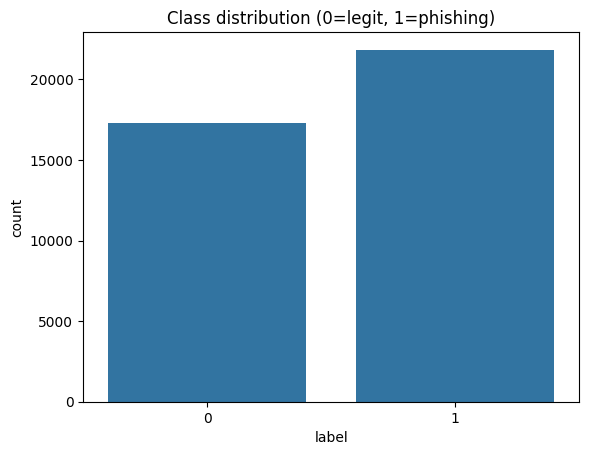

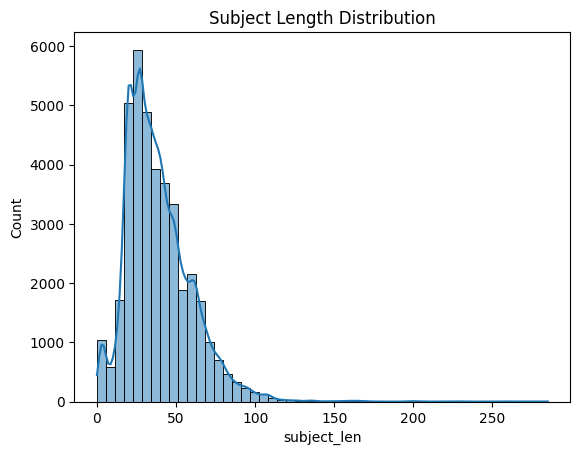

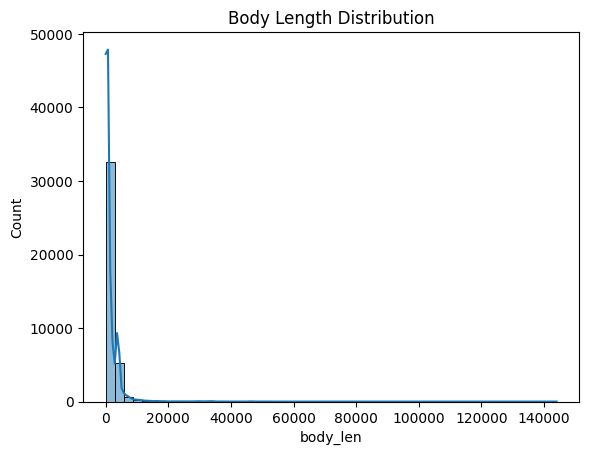

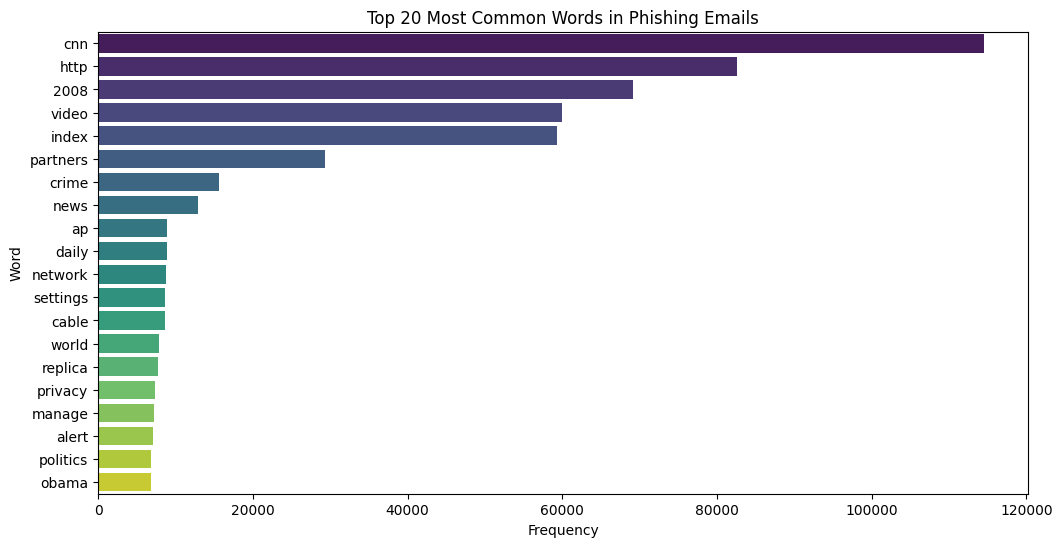

In [16]:
# Adjust these column names as needed
SENDER_COL = "sender"
SUBJECT_COL = "subject"
BODY_COL = "body"
TARGET_COL = "label"



# Quick stats
print("Dataset shape:", df.shape)
print("Class distribution:\n", df[TARGET_COL].value_counts())

# Visualization: class distribution
sns.countplot(x=TARGET_COL, data=df)
plt.title("Class distribution (0=legit, 1=phishing)")
plt.show()

# Optional: visualize subject/body length distributions
df['subject_len'] = df[SUBJECT_COL].apply(lambda x: len(str(x)))
df['body_len'] = df[BODY_COL].apply(lambda x: len(str(x)))

sns.histplot(df['subject_len'], bins=50, kde=True).set(title="Subject Length Distribution")
plt.show()

sns.histplot(df['body_len'], bins=50, kde=True).set(title="Body Length Distribution")
plt.show()
extra_stopwords = {"com", "www", "html", "email", "url", "08", "10", "05", "06", "s", "3", "4", "2", "1","6","8","01" }
# --- Most common words in phishing emails ---
# Filter phishing emails
phish_df = df[df[TARGET_COL] == 1]

# Combine subject + body into a single string
text_data = " ".join(phish_df[SUBJECT_COL].fillna("") + " " + phish_df[BODY_COL].fillna(""))

# Tokenize and count words, excluding common English stop words
words = [word.lower() for word in re.findall(r'\b\w+\b', text_data) if word.lower() not in ENGLISH_STOP_WORDS and word.lower() not in extra_stopwords]
word_counts = Counter(words)

# Get top 20 most common words
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Top 20 Most Common Words in Phishing Emails")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

In [17]:
class SenderFeatures(BaseEstimator, TransformerMixin):
    IP_RE = re.compile(r"^\[?\d{1,3}(\.\d{1,3}){3}\]?$")
    COMMON_PROVIDERS = ["gmail.com","yahoo.com","hotmail.com","outlook.com","live.com","icloud.com"]

    def fit(self, X, y=None): return self

    def transform(self, X):
        srs = pd.Series(X).fillna("").astype(str)
        def feat(addr):
            addr = addr.strip()
            username, domain = "", ""
            if "@" in addr:
                parts = addr.split("@",1)
                username, domain = parts[0], parts[1] if len(parts)>1 else ""
            else:
                domain = addr
            username_len = len(username)
            domain_len = len(domain)
            has_digit = int(bool(re.search(r"\d", username)) or bool(re.search(r"\d", domain)))
            num_dots = domain.count(".")
            has_plus = int("+" in username)
            sender_contains_ip = int(bool(self.IP_RE.match(domain.strip())))
            is_common_free = int(any(p in domain.lower() for p in self.COMMON_PROVIDERS))
            return [username_len, domain_len, has_digit, num_dots, has_plus, sender_contains_ip, is_common_free]
        return np.array(srs.map(feat).tolist(), dtype=float)

In [18]:
X = df[[SENDER_COL, SUBJECT_COL, BODY_COL]]
y = df[TARGET_COL].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, random_state=RANDOM_STATE
)

In [19]:
subject_tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2), stop_words='english')
body_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
sender_pipe = Pipeline([("sender_feats", SenderFeatures()), ("scaler", StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ("subj", subject_tfidf, SUBJECT_COL),
        ("body", body_tfidf, BODY_COL),
        ("sender", sender_pipe, SENDER_COL)
    ],
    remainder="drop",
    sparse_threshold=0.0
)

Baseline Accuracy: 0.5578484956837104


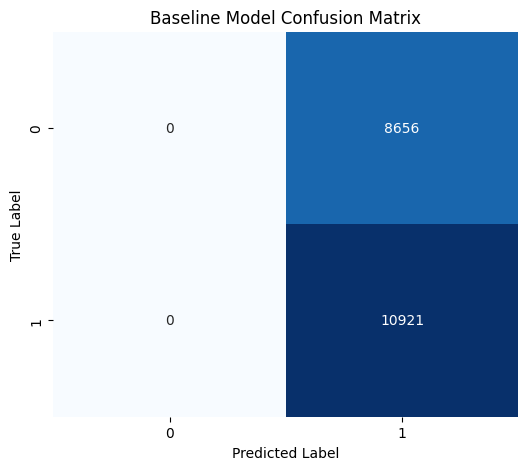

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Fit and predict (you already did this)
# baseline = Pipeline([("pre", preprocessor), ("clf", DummyClassifier(strategy="most_frequent"))])
# baseline.fit(X_train, y_train)
# y_pred_base = baseline.predict(X_test)

# Accuracy
print("Baseline Accuracy:", accuracy_score(y_test, y_pred_base))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_base)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Baseline Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [21]:
rf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced")
pipeline = Pipeline([("pre", preprocessor), ("clf", rf)])
print("Training Random Forest...")
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]


Training Random Forest...



Accuracy: 0.9944833222659243

ROC AUC: 0.999590028478769


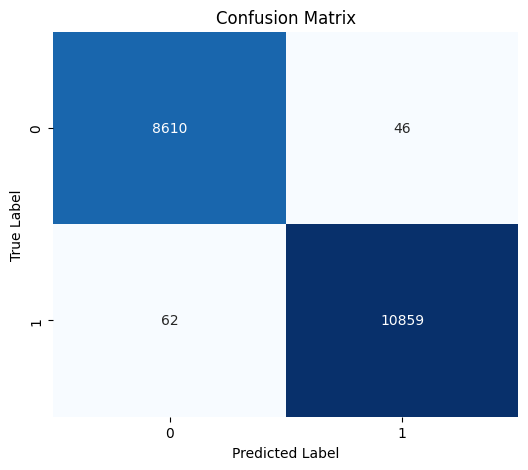

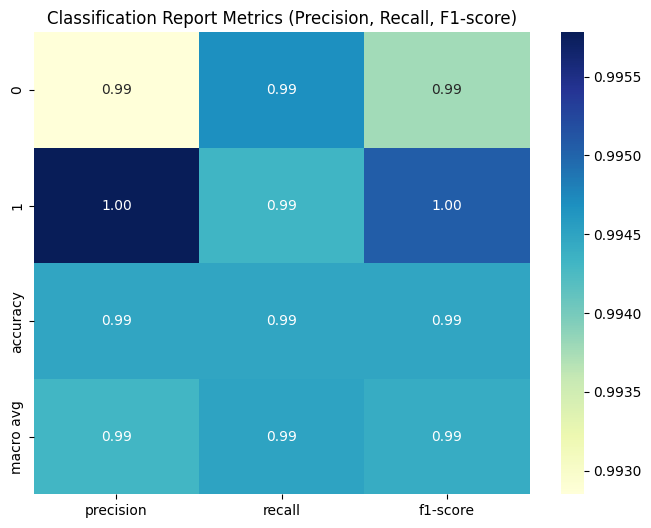

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

# Assuming you already have y_test, y_pred, y_proba
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nROC AUC:", roc_auc_score(y_test, y_proba))

# --- Confusion Matrix Visualization ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# --- Classification Report Visualization ---
# Convert classification report to DataFrame
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Remove support column for heatmap if desired
metrics_df = report_df.iloc[:-1, :-1]  # drop 'accuracy' row and 'support' column

plt.figure(figsize=(8,6))
sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Metrics (Precision, Recall, F1-score)")
plt.show()


In [23]:
try:
    rf_trained = pipeline.named_steps['clf']
    pre = pipeline.named_steps['pre']
    subj_feats = pre.named_transformers_['subj'].get_feature_names_out()
    body_feats = pre.named_transformers_['body'].get_feature_names_out()
    sender_feats = [f"sender_{i}" for i in range(7)]
    all_features = list(subj_feats) + list(body_feats) + sender_feats
    importances = rf_trained.feature_importances_
    top_idx = np.argsort(importances)[-20:][::-1]
    print("\nTop 20 features:")
    for i in top_idx:
        print(f"{all_features[i]}: {importances[i]:.5f}")
except:
    print("Could not extract feature importances.")


Top 20 features:
org: 0.04080
wrote: 0.03247
com: 0.02609
list: 0.02291
mailing: 0.01735
mail: 0.01457
like: 0.01432
message: 0.01426
10: 0.01340
http: 0.01329
email: 0.01312
2007: 0.01212
sender_6: 0.01168
opensuse: 0.01118
thanks: 0.01011
net: 0.00922
version: 0.00844
2008: 0.00788
use: 0.00762
unsubscribe: 0.00758
